# <p style="background-color:   #008080; font-family:newtimeroman;font-size:180%;color:#FFF9ED;text-align:center;border-radius:80px 20px;"><b>Titanic Prediction Project<img  style="width: 70x;"  style="position: absolute; right: 5px; top: 60%; transform: translateY(-70%);"> </div> 

<p style="text-align: center;"><img src="c.jpg" style="width: 100%; height: 500px; object-fit: cover;">
</p>

## ---------------------------- Titanic - Machine Learning from Disaster-----------------------------

- *Survived*: Whether the passenger survived or not (1 if survived, 0 if did not survive).
- *Pclass*: Passenger class, indicating the socio-economic status of the passenger (1 for first class, 2 for second class, 3 for third class).
- *Name*: The full name of the passenger.
- *Sex*: The gender of the passenger (male or female).
- *Age*: The age of the passenger.
- *SibSp*: The number of siblings or spouses the passenger had aboard the Titanic.
- *Parch*: The number of parents or children the passenger had aboard the Titanic.
- *Ticket*: The ticket number issued to the passenger.
- *Fare*: The amount of money the passenger paid for the ticket.
- *Cabin*: The cabin number where the passenger stayed.
- *Embarked*: The port where the passenger boarded the Titanic (C = Cherbourg, Q = Queenstown, S = Southampton).

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,f1_score, classification_report,confusion_matrix
from sklearn.metrics import  recall_score, precision_score, roc_auc_score, auc
#from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GridSearchCV
from yellowbrick.classifier import ClassPredictionError, ROCAUC
from sklearn.pipeline  import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from xgboost import XGBClassifier


plt.rcParams["figure.figsize"] = (9,5)
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)

## Read Data

In [112]:
df = pd.read_csv("train.csv")
prediction_test = pd.read_csv("test.csv")

## Data Preparation

In [3]:
df.sample(10)

# Encoding islemi Sex, Embarked

PassengerId  Survived  Pclass  \
253          254         0       3   
150          151         0       2   
40            41         0       3   
755          756         1       2   
537          538         1       1   
9             10         1       2   
115          116         0       3   
248          249         1       1   
889          890         1       1   
345          346         1       2   

                                               Name     Sex    Age  SibSp  \
253                        Lobb, Mr. William Arthur    male  30.00      1   
150                      Bateman, Rev. Robert James    male  51.00      0   
40   Ahlin, Mrs. Johan (Johanna Persdotter Larsson)  female  40.00      1   
755                       Hamalainen, Master. Viljo    male   0.67      1   
537                             LeRoy, Miss. Bertha  female  30.00      0   
9               Nasser, Mrs. Nicholas (Adele Achem)  female  14.00      1   
115                           Pekoniemi, Mr. Edvard    male  21.00      0   
248                   Beckwith, Mr. Richard Leonard    male  37.00      1   
889                           Behr, Mr. Karl Howell    male  26.00      0   
345                   Brown, Miss. Amelia "Mildred"  female  24.00      0   

     Parch             Ticket      Fare Cabin Embarked  
253      0          A/5. 3336   16.1000   NaN        S  
150      0        S.O.P. 1166   12.5250   NaN        S  
40       0               7546    9.4750   NaN        S  
755      1             250649   14.5000   NaN        S  
537      0           PC 17761  106.4250   NaN        C  
9        0             237736   30.0708   NaN        C  
115      0  STON/O 2. 3101294    7.9250   NaN        S  
248      1              11751   52.5542   D35        S  
889      0             111369   30.0000  C148        C  
345      0             248733   13.0000   F33        S

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.describe().T

count        mean         std   min       25%       50%    75%  \
PassengerId  891.0  446.000000  257.353842  1.00  223.5000  446.0000  668.5   
Survived     891.0    0.383838    0.486592  0.00    0.0000    0.0000    1.0   
Pclass       891.0    2.308642    0.836071  1.00    2.0000    3.0000    3.0   
Age          714.0   29.699118   14.526497  0.42   20.1250   28.0000   38.0   
SibSp        891.0    0.523008    1.102743  0.00    0.0000    0.0000    1.0   
Parch        891.0    0.381594    0.806057  0.00    0.0000    0.0000    0.0   
Fare         891.0   32.204208   49.693429  0.00    7.9104   14.4542   31.0   

                  max  
PassengerId  891.0000  
Survived       1.0000  
Pclass         3.0000  
Age           80.0000  
SibSp          8.0000  
Parch          6.0000  
Fare         512.3292

In [6]:
def is_hashable(v):
    try:
        hash(v)
    except TypeError:
        return False
    return True

def column_analysis(df):
    for column in df.columns:
        if all(df[column].apply(is_hashable)):
            unique_values = df[column].unique()
        else:
            unique_values = df[column].astype(str).unique()
            
        unique_count = len(unique_values)
        
        print(f"\033[1m\033[91mColumn:\033[0m \033[1m\033[94m{column}\033[0m")
        print(f"\033[1m\033[92mNumber of Unique Values:\033[93m {unique_count}")
        if unique_count <= 10:
            print(f"\033[1mUnique Values:\033[0m {unique_values}\n")
        else:
            print(f"\033[95mFirst 10 Unique Values:\033[0m {unique_values[:10]}")
            print(f"... and {unique_count - 10} more unique values\n")
        missing_count = df[column].isnull().sum()
        missing_percentage = (missing_count / len(df)) * 100
        print(f"\033[1mThe number of NaN values:\033[0m {missing_count}")
        print(f"\033[1mPercentage of NaN values:\033[0m {missing_percentage:.2f}%\n")
        
column_analysis(df)
    

Column: PassengerId
Number of Unique Values: 891
First 10 Unique Values: [ 1  2  3  4  5  6  7  8  9 10]
... and 881 more unique values

The number of NaN values: 0
Percentage of NaN values: 0.00%

Column: Survived
Number of Unique Values: 2
Unique Values: [0 1]

The number of NaN values: 0
Percentage of NaN values: 0.00%

Column: Pclass
Number of Unique Values: 3
Unique Values: [3 1 2]

The number of NaN values: 0
Percentage of NaN values: 0.00%

Column: Name
Number of Unique Values: 891
First 10 Unique Values: ['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina' 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'
 'Allen, Mr. William Henry' 'Moran, Mr. James' 'McCarthy, Mr. Timothy J'
 'Palsson, Master. Gosta Leonard'
 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)'
 'Nasser, Mrs. Nicholas (Adele Achem)']
... and 881 more unique values

The number of NaN values: 0
Percentage of NaN values: 0.00%

Column: Sex
Number of Unique Value

## Exploratory Data Analysis (EDA)

In [7]:
df['family'] = df['SibSp'] + df['Parch']
df = df.drop(columns = ['SibSp', 'Parch'])

In [8]:
df['alone'] = np.where(df['family'] == 0, 1, 0)

In [9]:
df.drop(['Cabin', 'Name', 'Ticket'], axis=1, inplace=True)

In [10]:
df

PassengerId  Survived  Pclass     Sex    Age      Fare Embarked  family  \
0              1         0       3    male  22.00    7.2500        S       1   
1              2         1       1  female  38.00   71.2833        C       1   
2              3         1       3  female  26.00    7.9250        S       0   
3              4         1       1  female  35.00   53.1000        S       1   
4              5         0       3    male  35.00    8.0500        S       0   
5              6         0       3    male    NaN    8.4583        Q       0   
6              7         0       1    male  54.00   51.8625        S       0   
7              8         0       3    male   2.00   21.0750        S       4   
8              9         1       3  female  27.00   11.1333        S       2   
9             10         1       2  female  14.00   30.0708        C       1   
10            11         1       3  female   4.00   16.7000        S       2   
11            12         1       1  female  58.00   26.5500        S       0   
12            13         0       3    male  20.00    8.0500        S       0   
13            14         0       3    male  39.00   31.2750        S       6   
14            15         0       3  female  14.00    7.8542        S       0   
15            16         1       2  female  55.00   16.0000        S       0   
16            17         0       3    male   2.00   29.1250        Q       5   
17            18         1       2    male    NaN   13.0000        S       0   
18            19         0       3  female  31.00   18.0000        S       1   
19            20         1       3  female    NaN    7.2250        C       0   
20            21         0       2    male  35.00   26.0000        S       0   
21            22         1       2    male  34.00   13.0000        S       0   
22            23         1       3  female  15.00    8.0292        Q       0   
23            24         1       1    male  28.00   35.5000        S       0   
24            25         0       3  female   8.00   21.0750        S       4   
25            26         1       3  female  38.00   31.3875        S       6   
26            27         0       3    male    NaN    7.2250        C       0   
27            28         0       1    male  19.00  263.0000        S       5   
28            29         1       3  female    NaN    7.8792        Q       0   
29            30         0       3    male    NaN    7.8958        S       0   
30            31         0       1    male  40.00   27.7208        C       0   
31            32         1       1  female    NaN  146.5208        C       1   
32            33         1       3  female    NaN    7.7500        Q       0   
33            34         0       2    male  66.00   10.5000        S       0   
34            35         0       1    male  28.00   82.1708        C       1   
35            36         0       1    male  42.00   52.0000        S       1   
36            37         1       3    male    NaN    7.2292        C       0   
37            38         0       3    male  21.00    8.0500        S       0   
38            39         0       3  female  18.00   18.0000        S       2   
39            40         1       3  female  14.00   11.2417        C       1   
40            41         0       3  female  40.00    9.4750        S       1   
41            42         0       2  female  27.00   21.0000        S       1   
42            43         0       3    male    NaN    7.8958        C       0   
43            44         1       2  female   3.00   41.5792        C       3   
44            45         1       3  female  19.00    7.8792        Q       0   
45            46         0       3    male    NaN    8.0500        S       0   
46            47         0       3    male    NaN   15.5000        Q       1   
47            48         1       3  female    NaN    7.7500        Q       0   
48            49         0       3    male    NaN   21.6792        C       2   
49   

# <p style="background-color:darkviolet; font-family:newtimeroman;color:#FFF9ED; font-size:150%; text-align:center; border-radius: 15px 50px;">  Handling with Null Values </p>

## Embarked

In [11]:
df["Embarked"].isna().sum()

2

In [12]:
from sklearn.impute import SimpleImputer

simple_imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
simple_imp.fit(df[["Embarked"]])
df[["Embarked"]] = simple_imp.fit_transform(df[["Embarked"]])

In [13]:
class_mapping = {'S': 0, 'C': 1, 'Q': 2}
df['Embarked'] = df['Embarked'].map(class_mapping)

In [14]:
df['Embarked'].value_counts()

Embarked
0    646
1    168
2     77
Name: count, dtype: int64

## Age

In [15]:
from sklearn.impute import KNNImputer

KNN_imputer = KNNImputer(n_neighbors = 4)
df[["Age"]] = KNN_imputer.fit_transform(df[["Age"]])

In [16]:
df["Age"].isna().sum()

0

## Pclass

In [17]:
class_mapping = {3:2, 2:1, 1:0}
df['Pclass'] = df['Pclass'].map(class_mapping)

In [18]:
df['Pclass'].value_counts()
# 2 = 3
# 0 = 1
# 1 = 2

Pclass
2    491
0    216
1    184
Name: count, dtype: int64

## Sex

In [19]:
class_mapping = {'female': 0, 'male': 1}
df['Sex'] = df['Sex'].map(class_mapping)

In [20]:
df['Sex'].value_counts()

Sex
1    577
0    314
Name: count, dtype: int64

In [21]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
Fare           0
Embarked       0
family         0
alone          0
dtype: int64

# <p style="background-color:darkviolet; font-family:newtimeroman;color:#FFF9ED; font-size:150%; text-align:center; border-radius: 15px 50px;">  Data Visualization </p>

In [22]:
def create_pie_chart_of_count(df, column_name):
    df_not_null = df[~df[column_name].isnull()]
    fig = px.pie(df_not_null.groupby([column_name]).size().reset_index(name='count'), names=column_name, values='count')
    fig.show()

create_pie_chart_of_count(df, 'Sex')
create_pie_chart_of_count(df, 'Embarked')
create_pie_chart_of_count(df, 'Survived')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


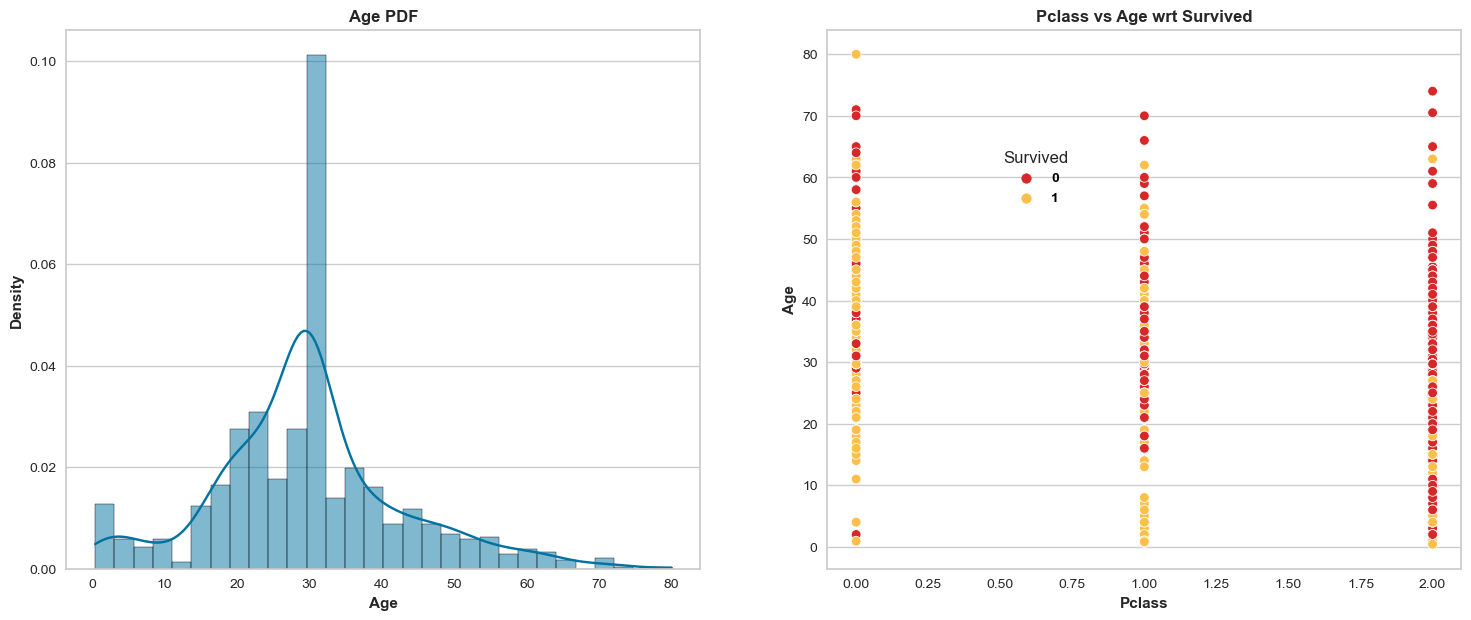

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

mean = df["Age"].mean()
mode = df["Age"].mode()
median = df["Age"].median()

sns.histplot(df["Age"], stat="density", kde=True, ax=axs[0])
axs[0].set_title("Age PDF", fontweight="bold")
axs[0].set_xlabel("Age", fontweight="bold")
axs[0].set_ylabel("Density", fontweight="bold")
l = axs[0].legend()
for text in l.get_texts():
    text.set_fontweight("bold")
    text.set_color("black")
axs[0].grid(axis="x")

sns.scatterplot(x=df["Pclass"], y=df["Age"], hue=df["Survived"], ax=axs[1],palette=["#d62828", "#fcbf49"])
axs[1].set_title("Pclass vs Age wrt Survived", fontweight="bold")
axs[1].set_xlabel("Pclass", fontweight="bold")
axs[1].set_ylabel("Age", fontweight="bold")
axs[1].grid(axis="x")
l = axs[1].legend(loc='upper right', bbox_to_anchor=(0.4, 0.8), title="Survived")
for text in l.get_texts():
    text.set_fontweight("bold")
    text.set_color("black")
plt.show();

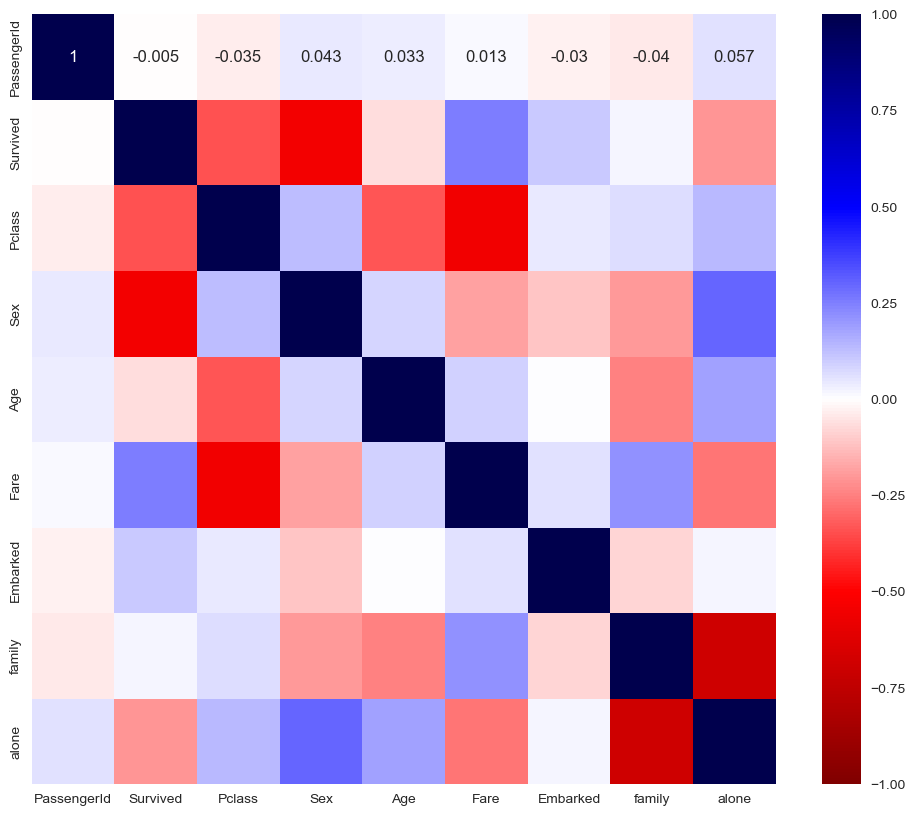

In [24]:
plt.figure(figsize=(12,10))
cor = df.corr(numeric_only=True)
sns.heatmap(cor, annot=True,
            cmap=plt.cm.seismic_r, vmin=-1, vmax=1)
plt.show()

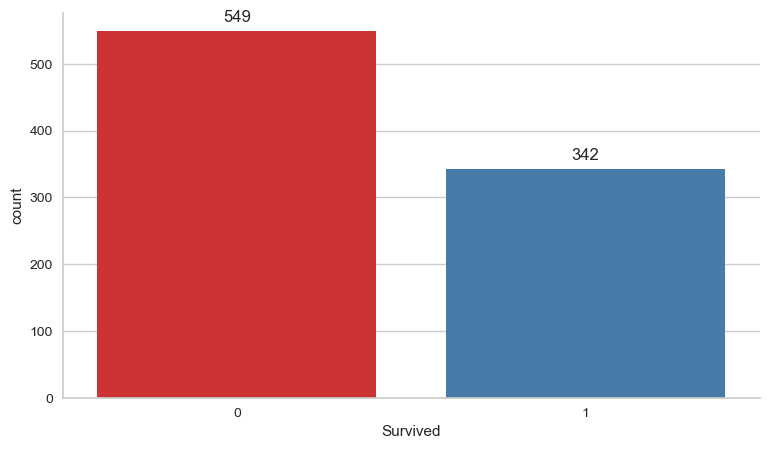

In [25]:
ax = sns.countplot(x=df["Survived"], palette='Set1')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')
plt.show()

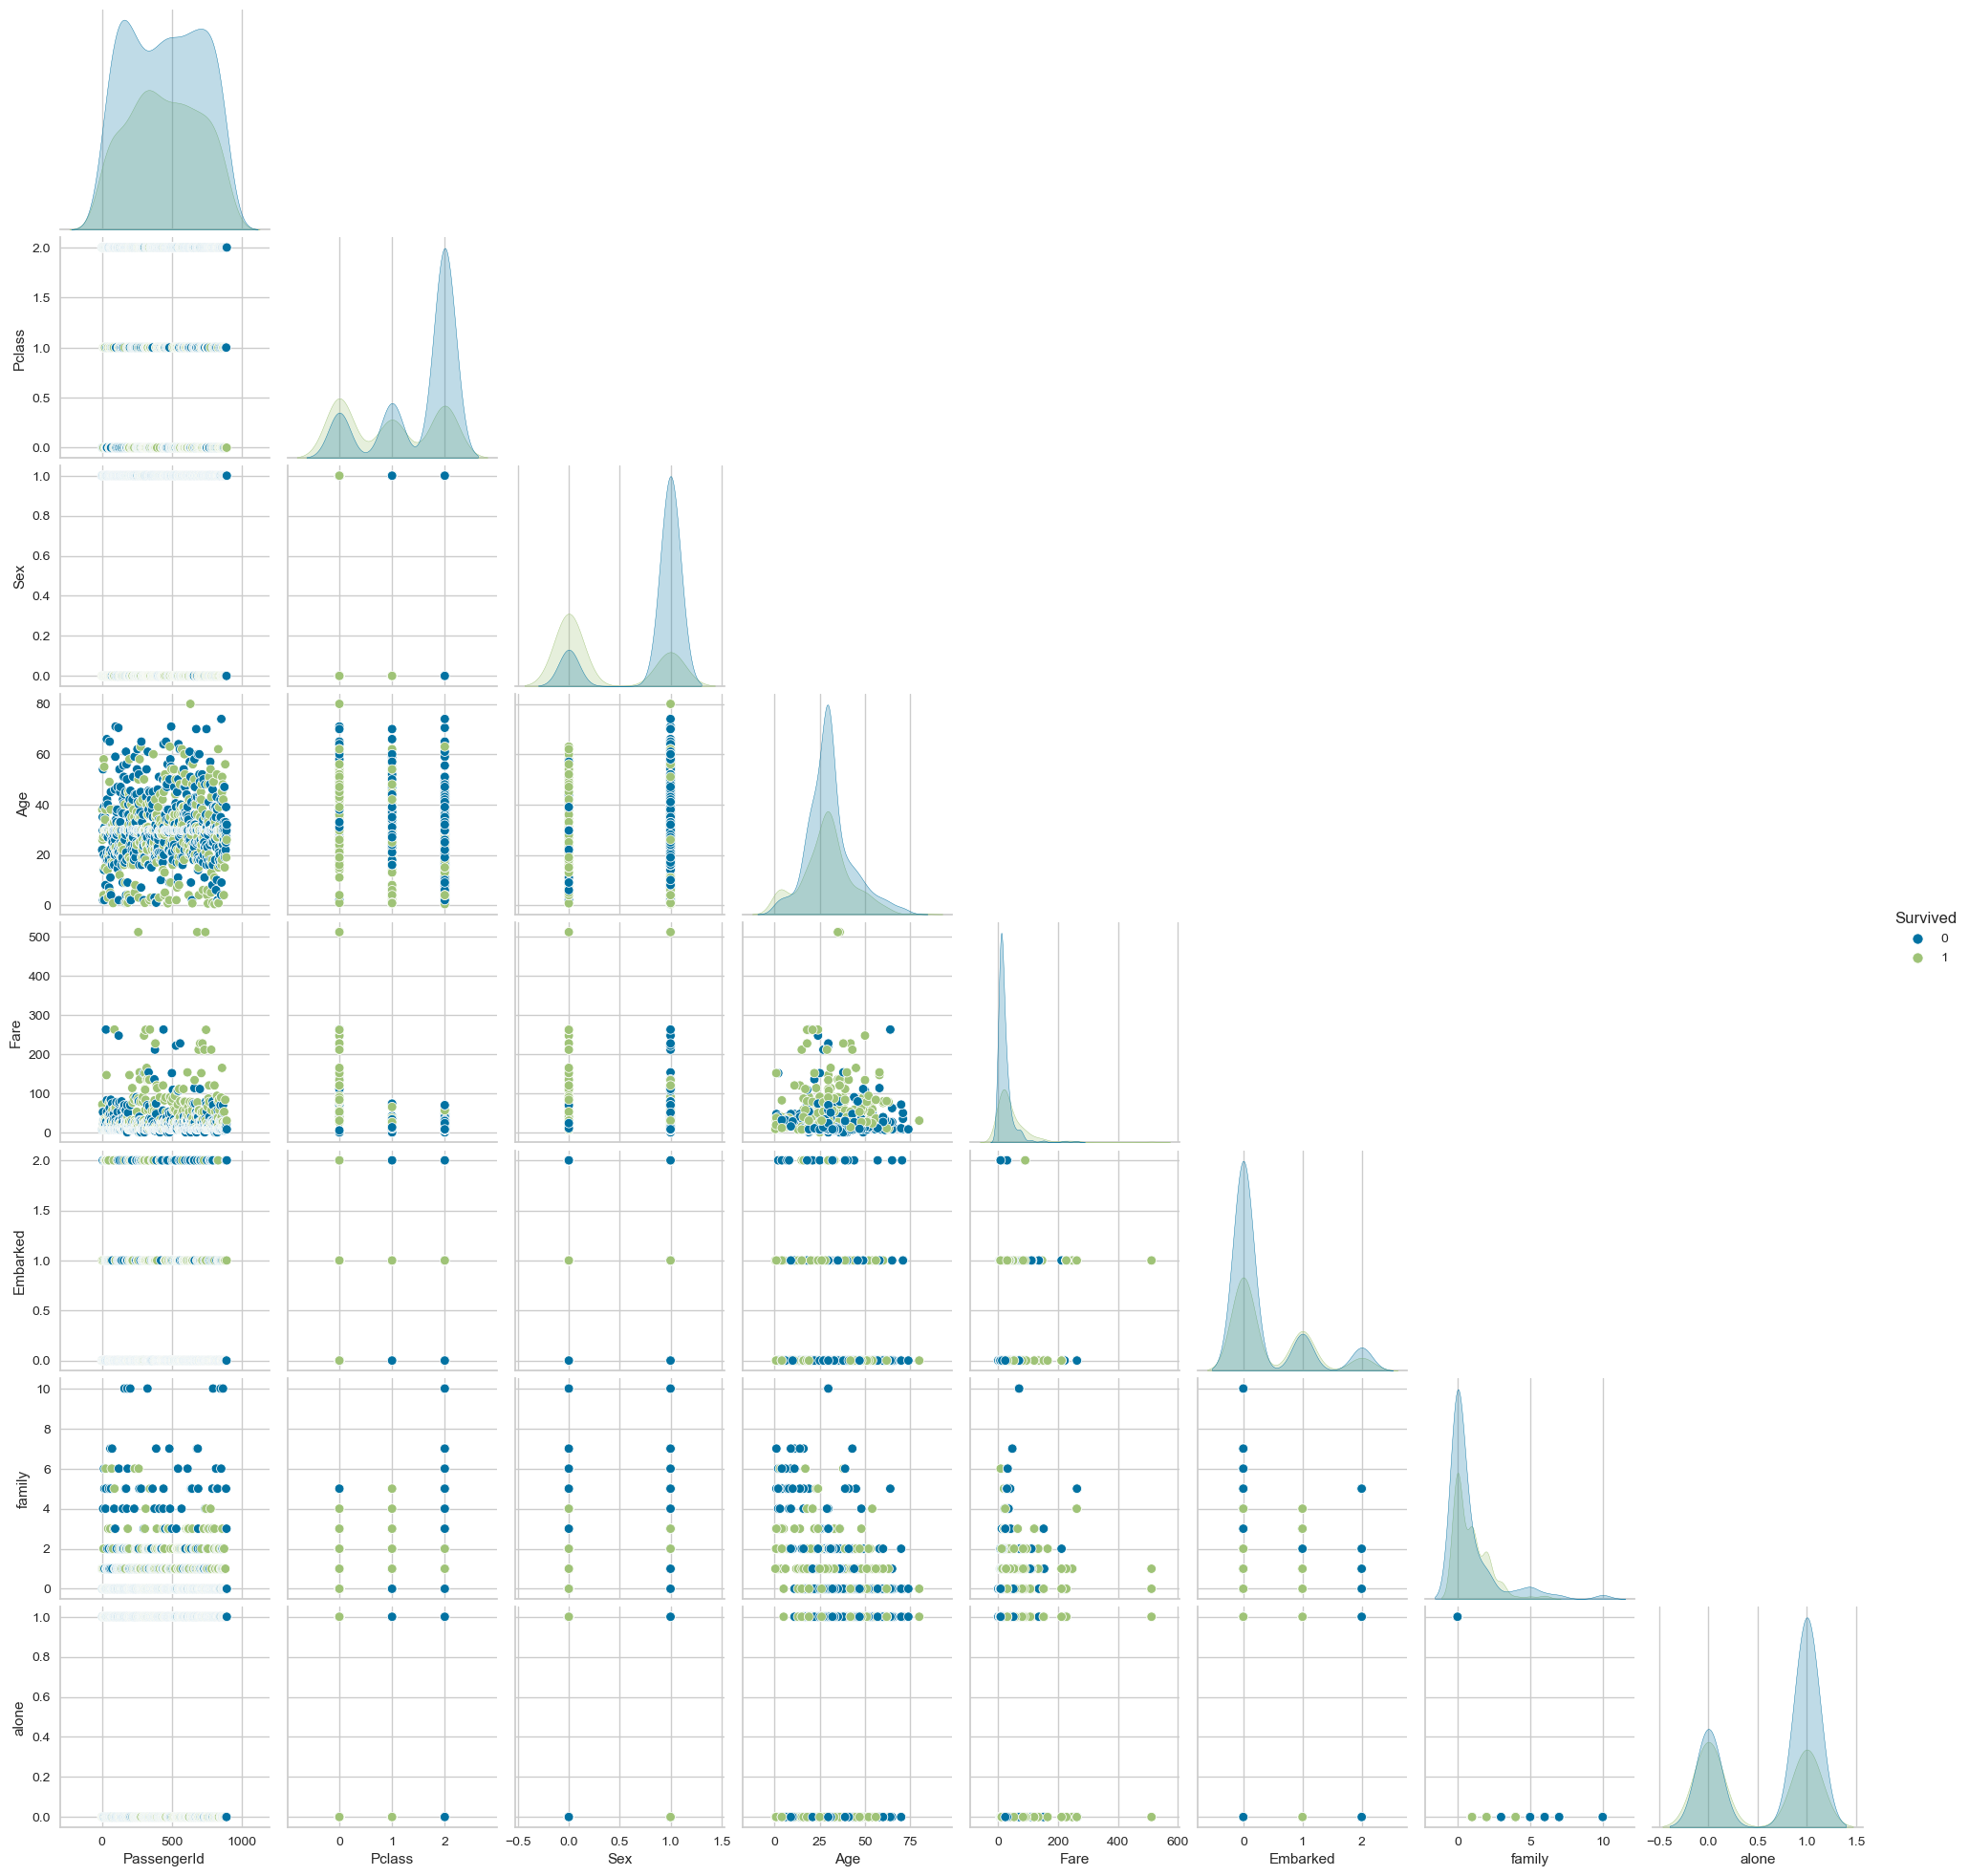

In [26]:
sns.pairplot(data=df, hue='Survived', corner=True);

In [27]:
survival_rate = df.groupby('Sex')['Survived'].mean() 
survival_rate
# 0 Female
# 1 Male 

Sex
0    0.742038
1    0.188908
Name: Survived, dtype: float64

In [28]:
df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

## Train | Test Split

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

In [30]:
X = df.drop('Survived', axis=1)
y = df['Survived']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=61, stratify=y, test_size=0.15)

In [32]:
print("Train features shape : ", X_train.shape)
print("Train target shape   : ", y_train.shape)
print("Test features shape  : ", X_test.shape)
print("Test target shape    : ", y_test.shape)

Train features shape :  (757, 8)
Train target shape   :  (757,)
Test features shape  :  (134, 8)
Test target shape    :  (134,)


In [33]:
cat = df.select_dtypes("object").columns
cat

Index([], dtype='object')

# AdaBoosting Classifier

## Vanilla AdaBoosting 

In [34]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate

In [35]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [36]:
ada_model = AdaBoostClassifier(n_estimators=50, random_state=61)
ada_model.fit(X_train, y_train)

AdaBoostClassifier(random_state=61)

In [37]:
eval_metric(ada_model, X_train, y_train, X_test, y_test)

Test_Set
[[75  8]
 [17 34]]
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        83
           1       0.81      0.67      0.73        51

    accuracy                           0.81       134
   macro avg       0.81      0.79      0.79       134
weighted avg       0.81      0.81      0.81       134


Train_Set
[[407  59]
 [ 73 218]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       466
           1       0.79      0.75      0.77       291

    accuracy                           0.83       757
   macro avg       0.82      0.81      0.81       757
weighted avg       0.82      0.83      0.82       757



# GridSearch AdaBoosting 

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [39]:
model_pipeline = Pipeline([('scaler', StandardScaler()), ('AdaBoost', AdaBoostClassifier(random_state=42))])

In [40]:
param_grid = {
    "AdaBoost__n_estimators": [50, 100, 200],
    "AdaBoost__learning_rate": [0.01, 0.1, 0.5, 1]
}

In [41]:
ada_grid_model = GridSearchCV(model_pipeline, param_grid, cv=5, scoring="recall")
ada_grid_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('AdaBoost',
                                        AdaBoostClassifier(random_state=42))]),
             param_grid={'AdaBoost__learning_rate': [0.01, 0.1, 0.5, 1],
                         'AdaBoost__n_estimators': [50, 100, 200]},
             scoring='recall')

In [42]:
ada_grid_model.best_params_

{'AdaBoost__learning_rate': 0.1, 'AdaBoost__n_estimators': 200}

In [43]:
ada_grid_model.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('AdaBoost',
                 AdaBoostClassifier(learning_rate=0.1, n_estimators=200,
                                    random_state=42))])

In [44]:
ada_grid_model.best_score_

0.7250146113383986

In [45]:
y_pred = ada_grid_model.predict(X_test)
y_pred_proba = ada_grid_model.predict_proba(X_test)

ada_f1 = f1_score(y_test, y_pred)
ada_recall = recall_score(y_test, y_pred)
ada_auc = roc_auc_score(y_test, y_pred_proba[:,1])
eval_metric(ada_grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[75  8]
 [19 32]]
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        83
           1       0.80      0.63      0.70        51

    accuracy                           0.80       134
   macro avg       0.80      0.77      0.78       134
weighted avg       0.80      0.80      0.79       134


Train_Set
[[411  55]
 [ 77 214]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       466
           1       0.80      0.74      0.76       291

    accuracy                           0.83       757
   macro avg       0.82      0.81      0.81       757
weighted avg       0.82      0.83      0.82       757



### Feature_Importances

In [46]:
model = AdaBoostClassifier(n_estimators=50, learning_rate=0.5, random_state=61)
model.fit(X_train, y_train)
model.feature_importances_

feats = pd.DataFrame(index=X.columns, data= model.feature_importances_, columns=['ada_importance'])
ada_imp_feats = feats.sort_values("ada_importance", ascending = False)
ada_imp_feats

ada_importance
Age                    0.28
Fare                   0.28
PassengerId            0.14
Sex                    0.12
family                 0.12
Pclass                 0.04
Embarked               0.02
alone                  0.00

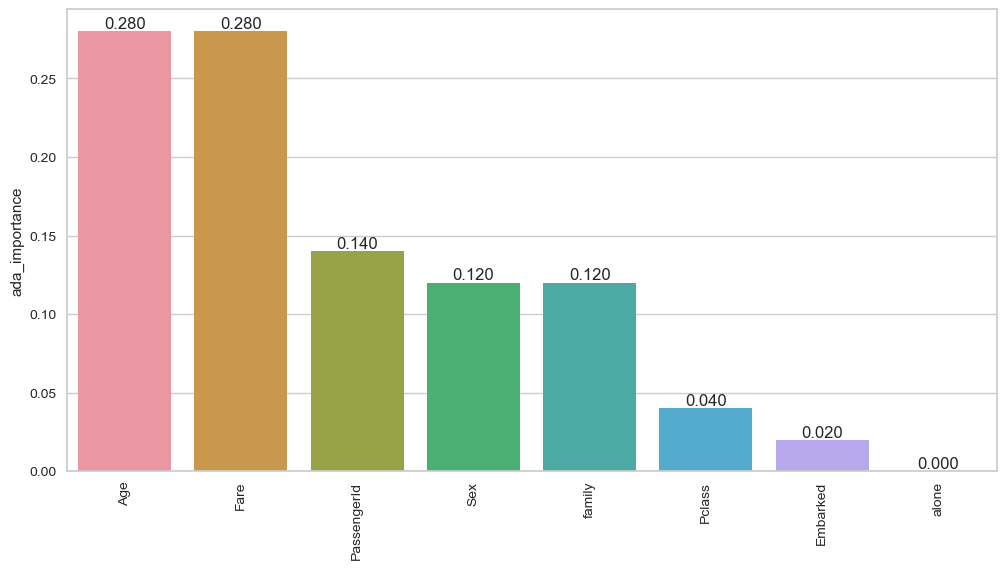

In [47]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=ada_imp_feats, x=ada_imp_feats.index, y='ada_importance')
ax.bar_label(ax.containers[0], fmt="%.3f")
plt.xticks(rotation=90);

### Evaluating ROC Curves and AUC

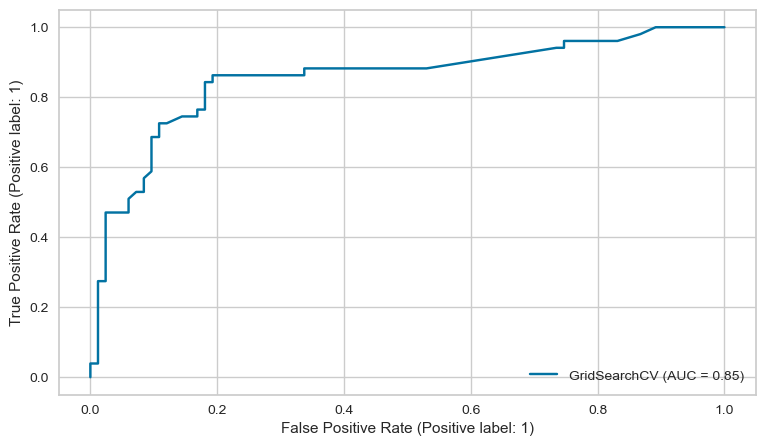

In [48]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(ada_grid_model, X_test, y_test);

# Gradient Boosting Classifier

## Vanilla Gradient Boosting

In [49]:
from sklearn.ensemble import GradientBoostingClassifier

In [50]:
grad_model = GradientBoostingClassifier(random_state=61)
grad_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=61)

In [51]:
eval_metric(grad_model, X_train, y_train, X_test, y_test)

Test_Set
[[78  5]
 [15 36]]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        83
           1       0.88      0.71      0.78        51

    accuracy                           0.85       134
   macro avg       0.86      0.82      0.83       134
weighted avg       0.85      0.85      0.85       134


Train_Set
[[449  17]
 [ 54 237]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       466
           1       0.93      0.81      0.87       291

    accuracy                           0.91       757
   macro avg       0.91      0.89      0.90       757
weighted avg       0.91      0.91      0.90       757



## GridSearch Gradient Boosting

In [52]:
model_pipeline = Pipeline([('scaler', StandardScaler()), ('GBM', GradientBoostingClassifier(random_state=61))])

In [53]:
param_grid = {
    "GBM__n_estimators": [100, 200, 300],
    "GBM__subsample": [0.8, 0.10],
    "GBM__max_features": [None, 2, 3],
    "GBM__learning_rate": [0.01, 0.1, 0.5, 0.7],
    "GBM__max_depth": [4, 7]
}

In [54]:
gbm_grid = GridSearchCV(model_pipeline, param_grid, scoring= "recall").fit(X_train, y_train)

In [55]:
gbm_grid.best_params_

{'GBM__learning_rate': 0.1,
 'GBM__max_depth': 4,
 'GBM__max_features': 3,
 'GBM__n_estimators': 300,
 'GBM__subsample': 0.8}

In [56]:
gbm_grid.best_score_

0.742197545295149

In [57]:
y_pred = gbm_grid.predict(X_test)

gb_f1 = f1_score(y_test, y_pred)
gb_recall = recall_score(y_test, y_pred)
gb_auc = roc_auc_score(y_test, y_pred)

eval_metric(gbm_grid, X_train, y_train, X_test, y_test)

Test_Set
[[75  8]
 [16 35]]
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        83
           1       0.81      0.69      0.74        51

    accuracy                           0.82       134
   macro avg       0.82      0.79      0.80       134
weighted avg       0.82      0.82      0.82       134


Train_Set
[[466   0]
 [  1 290]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       466
           1       1.00      1.00      1.00       291

    accuracy                           1.00       757
   macro avg       1.00      1.00      1.00       757
weighted avg       1.00      1.00      1.00       757



### Feature Importances

In [58]:
model = GradientBoostingClassifier(learning_rate=0.5, max_features= None,
                                   max_depth=4, n_estimators = 100, 
                                   subsample = 0.1, random_state=61)
model.fit(X_train, y_train)

model.feature_importances_

feats = pd.DataFrame(index=X.columns, data=model.feature_importances_, columns=['grad_importance'])
grad_imp_feats = feats.sort_values("grad_importance")
grad_imp_feats

grad_importance
alone               0.004956
Embarked            0.032497
Pclass              0.058540
Age                 0.091443
family              0.103248
Sex                 0.142440
Fare                0.242758
PassengerId         0.324119

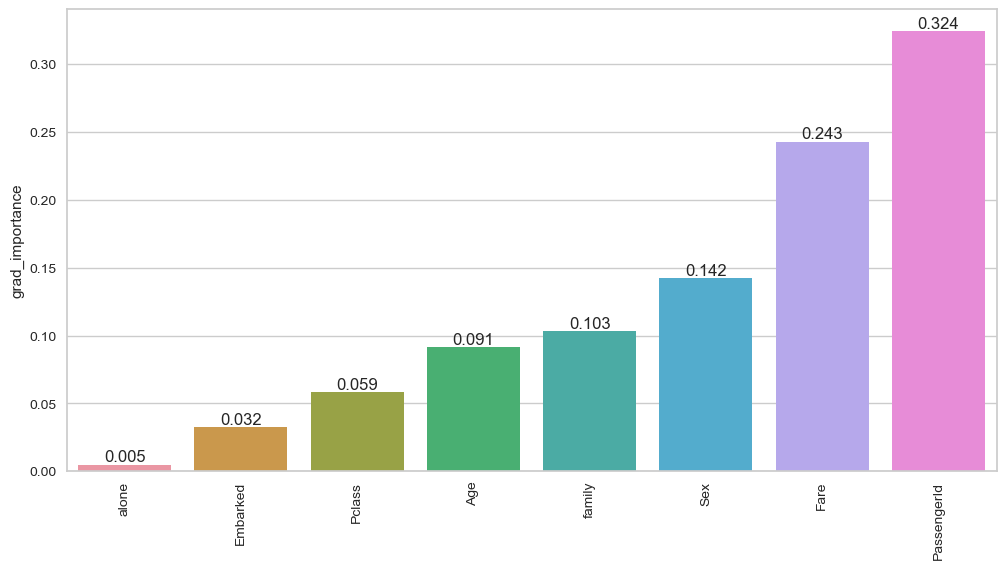

In [59]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=grad_imp_feats,
                 x=grad_imp_feats.index,
                 y='grad_importance')
ax.bar_label(ax.containers[0], fmt="%.3f")

plt.xticks(rotation=90);

### Evaluating ROC Curves and AUC

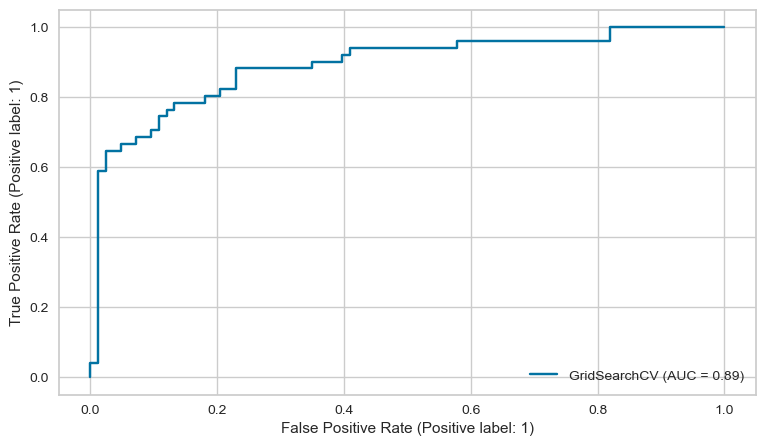

In [60]:
RocCurveDisplay.from_estimator(gbm_grid, X_test, y_test);

# XGBoosting Classifier

## Vanilla XGBoosting

In [61]:
from xgboost import XGBClassifier

In [62]:
xgb = XGBClassifier(random_state = 61).fit(X_train, y_train)

In [63]:
eval_metric(xgb, X_train, y_train, X_test, y_test)

Test_Set
[[73 10]
 [14 37]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        83
           1       0.79      0.73      0.76        51

    accuracy                           0.82       134
   macro avg       0.81      0.80      0.81       134
weighted avg       0.82      0.82      0.82       134


Train_Set
[[466   0]
 [  0 291]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       466
           1       1.00      1.00      1.00       291

    accuracy                           1.00       757
   macro avg       1.00      1.00      1.00       757
weighted avg       1.00      1.00      1.00       757



## Gridsearch for XGBoost

In [64]:
model_pipeline = Pipeline([('scaler', StandardScaler()), ('XGB', XGBClassifier(random_state=42))])

In [65]:
param_grid = {
    "XGB__n_estimators": [50, 100, 200, 250],
    "XGB__max_depth": [2, 3, 4, 5],
    "XGB__learning_rate": [0.01, 0.05, 0.1, 0.5],
    "XGB__subsample": [0.5, 0.8, 0.10],
    "XGB__colsample_bytree": [0.5, 0.8, 0.10]
}

In [66]:
xgb_grid = GridSearchCV(model_pipeline,
                        param_grid,
                        scoring="recall",
                        n_jobs=-1,
                        return_train_score=True).fit(X_train, y_train)

In [67]:
xgb_grid.best_params_

{'XGB__colsample_bytree': 0.5,
 'XGB__learning_rate': 0.5,
 'XGB__max_depth': 2,
 'XGB__n_estimators': 100,
 'XGB__subsample': 0.5}

In [68]:
xgb_grid.best_score_

0.7320280537697252

In [69]:
y_pred = xgb_grid.predict(X_test)

xgb_f1 = f1_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_auc = roc_auc_score(y_test, y_pred)

eval_metric(xgb_grid, X_train, y_train, X_test, y_test)

Test_Set
[[73 10]
 [15 36]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        83
           1       0.78      0.71      0.74        51

    accuracy                           0.81       134
   macro avg       0.81      0.79      0.80       134
weighted avg       0.81      0.81      0.81       134


Train_Set
[[444  22]
 [ 68 223]]
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       466
           1       0.91      0.77      0.83       291

    accuracy                           0.88       757
   macro avg       0.89      0.86      0.87       757
weighted avg       0.88      0.88      0.88       757



### Feature Importances in XGBoost

In [70]:
model = XGBClassifier(n_estimators= 200, 
                      colsample_bytree = 0.8, subsample= 0.8, 
                      learning_rate = 0.5,max_depth= 2, 
                      random_state = 61)

model.fit(X_train, y_train)

model.feature_importances_

feats = pd.DataFrame(index=X.columns, data=model.feature_importances_, columns=['xgb_importance'])
xgb_imp_feats = feats.sort_values("xgb_importance")
xgb_imp_feats

xgb_importance
Embarked           0.047215
PassengerId        0.050680
Age                0.057636
Fare               0.058896
alone              0.073436
family             0.078798
Pclass             0.183329
Sex                0.450008

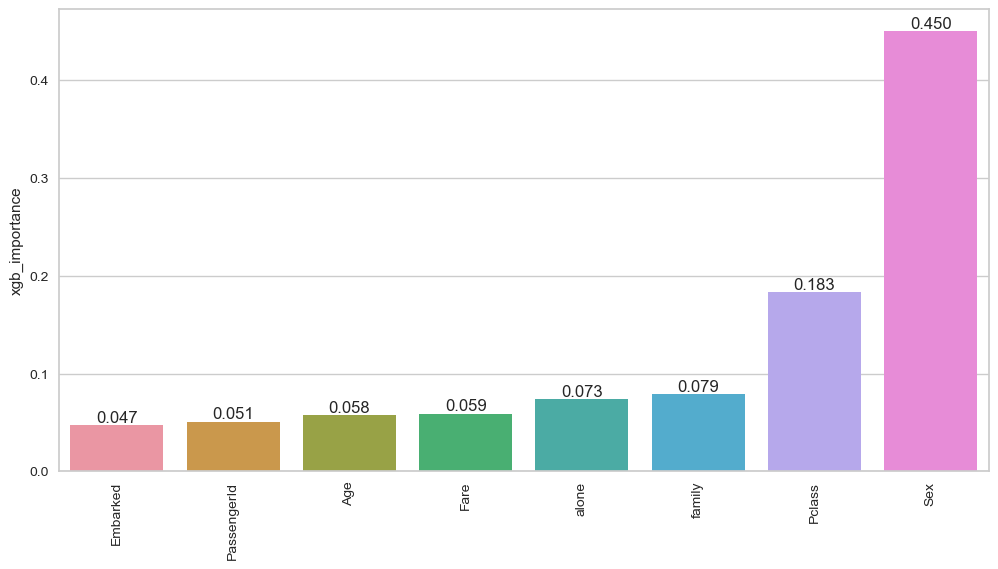

In [71]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=xgb_imp_feats, x=xgb_imp_feats.index, y='xgb_importance')
ax.bar_label(ax.containers[0],fmt="%.3f")

plt.xticks(rotation=90);

### Evaluating ROC Curves and AUC

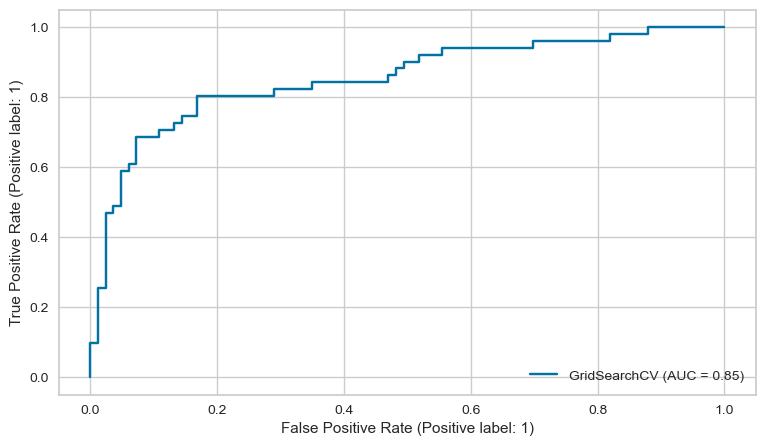

In [72]:
RocCurveDisplay.from_estimator(xgb_grid, X_test, y_test);

# Light GBM

In [73]:
from lightgbm import LGBMClassifier

## Vanilla Light GBM

In [74]:
lgbm_model = LGBMClassifier(random_state=61).fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 291, number of negative: 466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 461
[LightGBM] [Info] Number of data points in the train set: 757, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384412 -> initscore=-0.470862
[LightGBM] [Info] Start training from score -0.470862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [75]:
eval_metric(lgbm_model, X_train, y_train, X_test, y_test)

Test_Set
[[76  7]
 [13 38]]
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        83
           1       0.84      0.75      0.79        51

    accuracy                           0.85       134
   macro avg       0.85      0.83      0.84       134
weighted avg       0.85      0.85      0.85       134


Train_Set
[[466   0]
 [  1 290]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       466
           1       1.00      1.00      1.00       291

    accuracy                           1.00       757
   macro avg       1.00      1.00      1.00       757
weighted avg       1.00      1.00      1.00       757



## Gridsearch for Light GBM

In [76]:
model_pipeline = Pipeline([('scaler', StandardScaler()), ('LGBM', LGBMClassifier(random_state=61))])

In [77]:
param_grid = {
    'LGBM__learning_rate': [0.1, 1],
    'LGBM__n_estimators': [50, 100, 200],
    'LGBM__num_leaves': [20, 30, 50],  
    'LGBM__max_depth': [-1, 3, 4, 5],     
    'LGBM__subsample': [0.8, 1.0],
    'LGBM__colsample_bytree': [0.8, 1.0]
}

In [78]:
lgbm_grid = GridSearchCV(estimator=model_pipeline,
                         param_grid=param_grid,
                         cv=5,
                         scoring='recall',
                         n_jobs=-1,
                         return_train_score=True).fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 291, number of negative: 466
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 757, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384412 -> initscore=-0.470862
[LightGBM] [Info] Start training from score -0.470862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [79]:
lgbm_grid.best_params_

{'LGBM__colsample_bytree': 0.8,
 'LGBM__learning_rate': 1,
 'LGBM__max_depth': 4,
 'LGBM__n_estimators': 100,
 'LGBM__num_leaves': 20,
 'LGBM__subsample': 0.8}

In [80]:
lgbm_grid.best_score_

0.7182349503214495

In [81]:
y_pred = lgbm_grid.predict(X_test)

lgbm_f1 = f1_score(y_test, y_pred)
lgbm_recall = recall_score(y_test, y_pred)
lgbm_auc = roc_auc_score(y_test, y_pred)

eval_metric(lgbm_grid, X_train, y_train, X_test, y_test)

Test_Set
[[72 11]
 [15 36]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        83
           1       0.77      0.71      0.73        51

    accuracy                           0.81       134
   macro avg       0.80      0.79      0.79       134
weighted avg       0.80      0.81      0.80       134


Train_Set
[[466   0]
 [  0 291]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       466
           1       1.00      1.00      1.00       291

    accuracy                           1.00       757
   macro avg       1.00      1.00      1.00       757
weighted avg       1.00      1.00      1.00       757



### Feature Importances

In [82]:
model = LGBMClassifier(random_state=61, colsample_bytree = 0.8, 
                       subsample= 0.8, learning_rate= 1, 
                       max_depth= -1, n_estimators=50,
                      num_leaves= 20)
model.fit(X_train, y_train)

model.feature_importances_

feats = pd.DataFrame(index=X.columns, data=model.feature_importances_, columns=['lgbm_importance'])
lgbm_imp_feats = feats.sort_values("lgbm_importance")
lgbm_imp_feats

[LightGBM] [Info] Number of positive: 291, number of negative: 466
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 461
[LightGBM] [Info] Number of data points in the train set: 757, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384412 -> initscore=-0.470862
[LightGBM] [Info] Start training from score -0.470862


lgbm_importance
alone                      9
Pclass                    26
Sex                       30
Embarked                  42
family                    43
Age                      235
Fare                     248
PassengerId              317

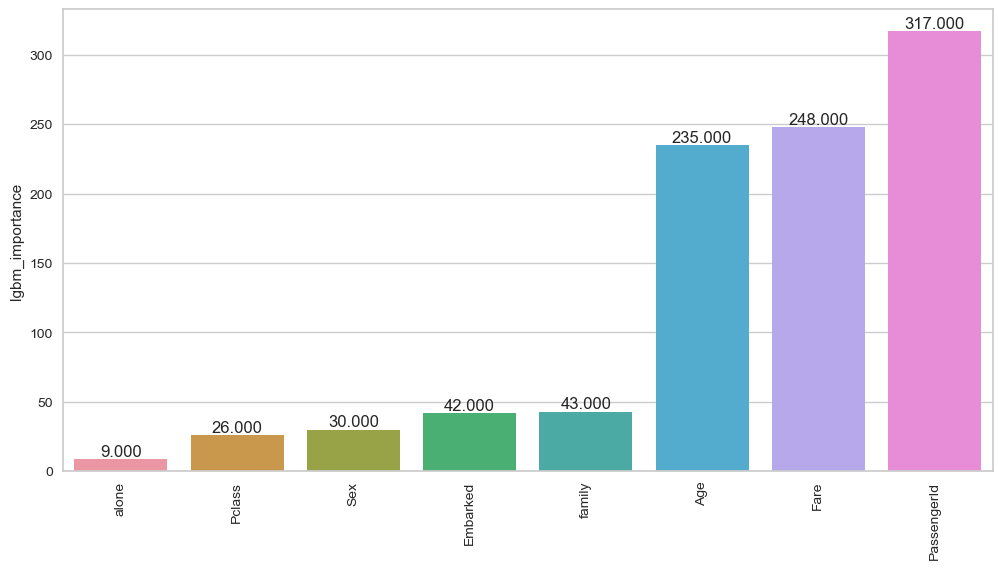

In [83]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=lgbm_imp_feats, x=lgbm_imp_feats.index, y='lgbm_importance')
ax.bar_label(ax.containers[0],fmt="%.3f")

plt.xticks(rotation=90);

### Evaluating ROC Curves and AUC

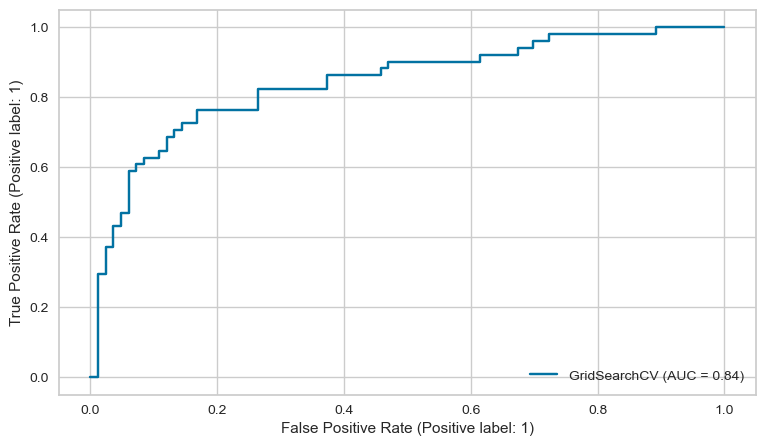

In [84]:
RocCurveDisplay.from_estimator(lgbm_grid, X_test, y_test);

# Random Forests

In [85]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=61)
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)
rf_f1 = f1_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_auc = roc_auc_score(y_test, y_pred)
eval_metric(rf_model, X_train, y_train, X_test, y_test)

Test_Set
[[76  7]
 [14 37]]
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        83
           1       0.84      0.73      0.78        51

    accuracy                           0.84       134
   macro avg       0.84      0.82      0.83       134
weighted avg       0.84      0.84      0.84       134


Train_Set
[[466   0]
 [  0 291]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       466
           1       1.00      1.00      1.00       291

    accuracy                           1.00       757
   macro avg       1.00      1.00      1.00       757
weighted avg       1.00      1.00      1.00       757



# Decision Tree

In [86]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=61)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
dt_f1 = f1_score(y_test, y_pred)
dt_recall = recall_score(y_test, y_pred)
dt_auc = roc_auc_score(y_test, y_pred)
eval_metric(dt_model, X_train, y_train, X_test, y_test)

Test_Set
[[64 19]
 [23 28]]
              precision    recall  f1-score   support

           0       0.74      0.77      0.75        83
           1       0.60      0.55      0.57        51

    accuracy                           0.69       134
   macro avg       0.67      0.66      0.66       134
weighted avg       0.68      0.69      0.68       134


Train_Set
[[466   0]
 [  0 291]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       466
           1       1.00      1.00      1.00       291

    accuracy                           1.00       757
   macro avg       1.00      1.00      1.00       757
weighted avg       1.00      1.00      1.00       757



# Logistic Regression

In [87]:
from sklearn.linear_model import LogisticRegression

In [88]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_model=LogisticRegression()
log_model.fit(X_train_scaled, y_train)
y_pred=log_model.predict(X_test_scaled)
log_f1 = f1_score(y_test, y_pred)
log_recall = recall_score(y_test, y_pred)
log_auc = roc_auc_score(y_test, y_pred)
eval_metric(log_model, X_train_scaled, y_train, X_test_scaled, y_test)

Test_Set
[[76  7]
 [19 32]]
              precision    recall  f1-score   support

           0       0.80      0.92      0.85        83
           1       0.82      0.63      0.71        51

    accuracy                           0.81       134
   macro avg       0.81      0.77      0.78       134
weighted avg       0.81      0.81      0.80       134


Train_Set
[[405  61]
 [ 85 206]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       466
           1       0.77      0.71      0.74       291

    accuracy                           0.81       757
   macro avg       0.80      0.79      0.79       757
weighted avg       0.81      0.81      0.81       757



# KNN

In [89]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)
y_pred = knn_model.predict(X_test_scaled)
knn_f1 = f1_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)
knn_auc = roc_auc_score(y_test, y_pred)
eval_metric(knn_model, X_train_scaled, y_train, X_test_scaled, y_test)

Test_Set
[[77  6]
 [15 36]]
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        83
           1       0.86      0.71      0.77        51

    accuracy                           0.84       134
   macro avg       0.85      0.82      0.83       134
weighted avg       0.84      0.84      0.84       134


Train_Set
[[431  35]
 [ 67 224]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       466
           1       0.86      0.77      0.81       291

    accuracy                           0.87       757
   macro avg       0.87      0.85      0.85       757
weighted avg       0.87      0.87      0.86       757



# SVC

In [90]:
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)
svc_f1 = f1_score(y_test, y_pred)
svc_recall = recall_score(y_test, y_pred)
svc_auc = roc_auc_score(y_test, y_pred)
eval_metric(svm_model, X_train_scaled, y_train, X_test_scaled, y_test)

Test_Set
[[77  6]
 [19 32]]
              precision    recall  f1-score   support

           0       0.80      0.93      0.86        83
           1       0.84      0.63      0.72        51

    accuracy                           0.81       134
   macro avg       0.82      0.78      0.79       134
weighted avg       0.82      0.81      0.81       134


Train_Set
[[422  44]
 [ 79 212]]
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       466
           1       0.83      0.73      0.78       291

    accuracy                           0.84       757
   macro avg       0.84      0.82      0.82       757
weighted avg       0.84      0.84      0.84       757



# Comparing Models

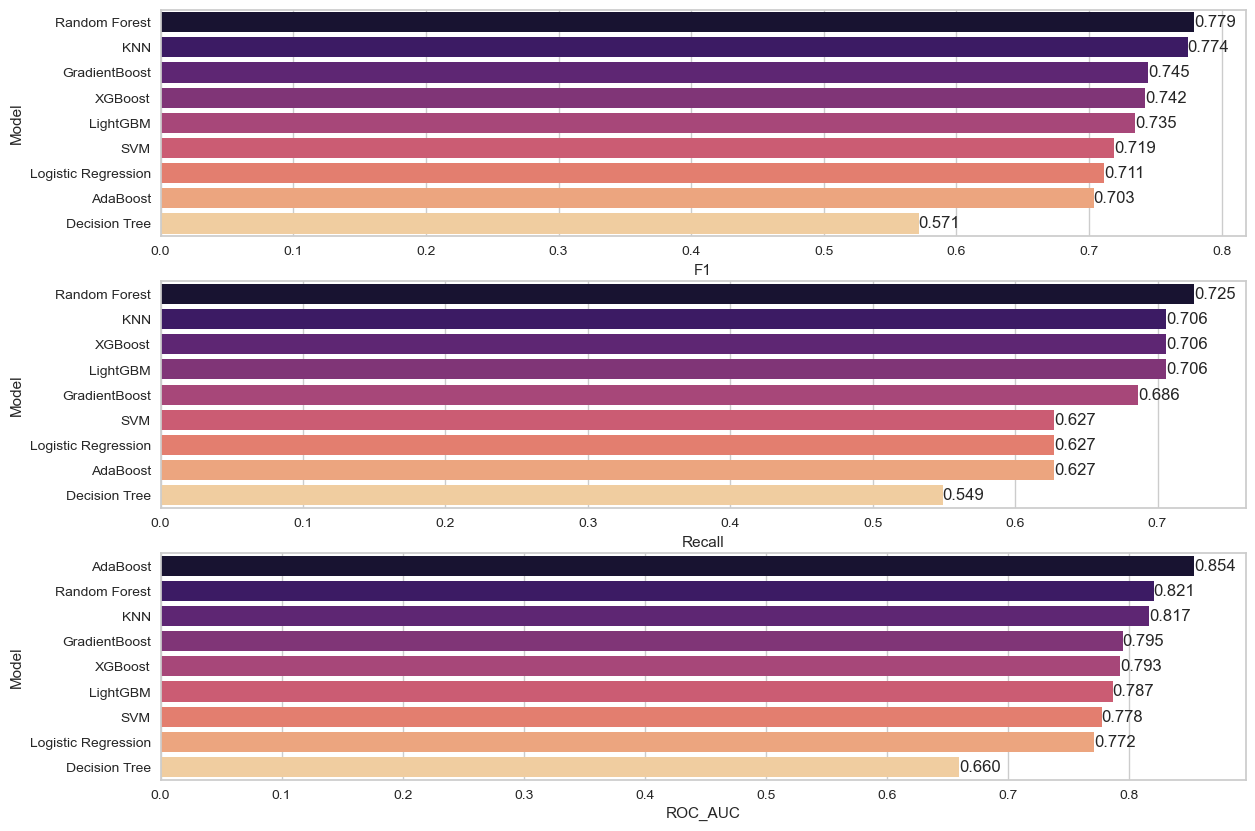

In [91]:
compare = pd.DataFrame({"Model": ["Logistic Regression", "KNN", "SVM", "Decision Tree", "Random Forest", "AdaBoost",
                                 "GradientBoost", "XGBoost", "LightGBM"],
                        "F1": [log_f1, knn_f1, svc_f1, dt_f1, rf_f1, ada_f1, gb_f1, xgb_f1, lgbm_f1],
                        "Recall": [log_recall, knn_recall, svc_recall, dt_recall, rf_recall, ada_recall, gb_recall, xgb_recall, lgbm_recall],
                        "ROC_AUC": [log_auc, knn_auc, svc_auc, dt_auc, rf_auc, ada_auc, gb_auc, xgb_auc, lgbm_auc]})

def labels(ax):
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.3f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment
    
plt.figure(figsize=(14,10))
plt.subplot(311)
compare = compare.sort_values(by="F1", ascending=False)
ax=sns.barplot(x="F1", y="Model", data=compare, palette="magma")
labels(ax)

plt.subplot(312)
compare = compare.sort_values(by="Recall", ascending=False)
ax=sns.barplot(x="Recall", y="Model", data=compare, palette="magma")
labels(ax)

plt.subplot(313)
compare = compare.sort_values(by="ROC_AUC", ascending=False)
ax=sns.barplot(x="ROC_AUC", y="Model", data=compare, palette="magma")
labels(ax)
plt.show()

# Lazy Predict Kütüphanesi

In [92]:
from lazypredict.Supervised import LazyClassifier

In [93]:
pd.set_option('display.max_columns', None)

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 21.93it/s]

[LightGBM] [Info] Number of positive: 291, number of negative: 466
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 757, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384412 -> initscore=-0.470862
[LightGBM] [Info] Start training from score -0.470862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

# Final Model 

## Prediction Test EDA

In [130]:
gender_submission_df = pd.read_csv('gender_submission.csv')

In [131]:
gender_submission_df

PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
5            897         0
6            898         1
7            899         0
8            900         1
9            901         0
10           902         0
11           903         0
12           904         1
13           905         0
14           906         1
15           907         1
16           908         0
17           909         0
18           910         1
19           911         1
20           912         0
21           913         0
22           914         1
23           915         0
24           916         1
25           917         0
26           918         1
27           919         0
28           920         0
29           921         0
30           922         0
31           923         0
32           924         1
33           925         1
34           926         0
35           927         0
36           928         1
37           929         1
38           930         0
39           931         0
40           932         0
41           933         0
42           934         0
43           935         1
44           936         1
45           937         0
46           938         0
47           939         0
48           940         1
49           941         1
50           942         0
51           943         0
52           944         1
53           945         1
54           946         0
55           947         0
56           948         0
57           949         0
58           950         0
59           951         1
60           952         0
61           953         0
62           954         0
63           955         1
64           956         0
65           957         1
66           958         1
67           959         0
68           960         0
69           961         1
70           962         1
71           963         0
72           964         1
73           965         0
74           966         1
75           967         0
76           968         0
77           969         1
78           970         0
79           971         1
80           972         0
81           973         0
82           974         0
83           975         0
84           976         0
85           977         0
86           978         1
87           979         1
88           980         1
89           981         0
90           982         1
91           983         0
92           984         1
93           985         0
94           986         0
95           987         0
96           988         1
97           989         0
98           990         1
99           991         0
100          992         1
101          993         0
102          994         0
103          995         0
104          996         1
105          997         0
106          998         0
107          999         0
108         1000         0
109         1001         0
110         1002         0
111         1003         1
112         1004         1
113         1005         1
114         1006         1
115         1007         0
116         1008         0
117         1009         1
118         1010         0
119         1011         1
120         1012         1
121         1013         0
122         1014         1
123         1015         0
124         1016         0
125         1017         1
126         1018         0
127         1019         1
128         1020         0
129         1021         0
130         1022         0
131         1023         0
132         1024         1
133         1025         0
134         1026         0
135         1027         0
136         1028         0
137         1029         0
138         1030         1
139         1031         0
140         1032         1
141         1033         1
142         1034         0
143         1035         0
144         1036         0
145         1037         0
146         1038         0
147      

In [113]:
prediction_test

PassengerId  Pclass                                               Name  \
0            892       3                                   Kelly, Mr. James   
1            893       3                   Wilkes, Mrs. James (Ellen Needs)   
2            894       2                          Myles, Mr. Thomas Francis   
3            895       3                                   Wirz, Mr. Albert   
4            896       3       Hirvonen, Mrs. Alexander (Helga E Lindqvist)   
5            897       3                         Svensson, Mr. Johan Cervin   
6            898       3                               Connolly, Miss. Kate   
7            899       2                       Caldwell, Mr. Albert Francis   
8            900       3          Abrahim, Mrs. Joseph (Sophie Halaut Easu)   
9            901       3                            Davies, Mr. John Samuel   
10           902       3                                   Ilieff, Mr. Ylio   
11           903       1                         Jones, Mr. Charles Cresson   
12           904       1      Snyder, Mrs. John Pillsbury (Nelle Stevenson)   
13           905       2                               Howard, Mr. Benjamin   
14           906       1  Chaffee, Mrs. Herbert Fuller (Carrie Constance...   
15           907       2      del Carlo, Mrs. Sebastiano (Argenia Genovesi)   
16           908       2                                  Keane, Mr. Daniel   
17           909       3                                  Assaf, Mr. Gerios   
18           910       3                       Ilmakangas, Miss. Ida Livija   
19           911       3              Assaf Khalil, Mrs. Mariana (Miriam")"   
20           912       1                             Rothschild, Mr. Martin   
21           913       3                          Olsen, Master. Artur Karl   
22           914       1               Flegenheim, Mrs. Alfred (Antoinette)   
23           915       1                    Williams, Mr. Richard Norris II   
24           916       1    Ryerson, Mrs. Arthur Larned (Emily Maria Borie)   
25           917       3                            Robins, Mr. Alexander A   
26           918       1                       Ostby, Miss. Helene Ragnhild   
27           919       3                                  Daher, Mr. Shedid   
28           920       1                            Brady, Mr. John Bertram   
29           921       3                                  Samaan, Mr. Elias   
30           922       2                       Louch, Mr. Charles Alexander   
31           923       2                      Jefferys, Mr. Clifford Thomas   
32           924       3           Dean, Mrs. Bertram (Eva Georgetta Light)   
33           925       3  Johnston, Mrs. Andrew G (Elizabeth Lily" Watson)"   
34           926       1                           Mock, Mr. Philipp Edmund   
35           927       3   Katavelas, Mr. Vassilios (Catavelas Vassilios")"   
36           928       3                                Roth, Miss. Sarah A   
37           929       3                                 Cacic, Miss. Manda   
38           930       3                                    Sap, Mr. Julius   
39           931       3                                      Hee, Mr. Ling   
40           932       3                                   Karun, Mr. Franz   
41           933       1                        Franklin, Mr. Thomas Parham   
42           934       3                              Goldsmith, Mr. Nathan   
43           935       2              Corbett, Mrs. Walter H (Irene Colvin)   
44           936       1   Kimball, Mrs. Edwin Nelson Jr (Gertrude Parsons)   
45           937       3                    Peltomaki, Mr. Nikolai Johannes   
46           938       1                           Chevre, Mr. Paul Romaine   
47           939       3                           Shaughnessy, Mr. Patrick   
48           940       1    Bucknell, Mrs. William Robert (Emma Eliza Ward)   
49           941       3     Coutts, Mrs. William (Winn

### Drop Unnecessary Columns

In [114]:
prediction_test['family'] = prediction_test['SibSp'] + prediction_test['Parch']
prediction_test = prediction_test.drop(columns = ['SibSp', 'Parch'])

In [115]:
prediction_test['alone'] = np.where(prediction_test['family'] == 0, 1, 0)

In [116]:
prediction_test.drop(['Cabin', 'Name', 'Ticket'], axis=1, inplace=True)

### Embarked

In [117]:
simple_imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
simple_imp.fit(prediction_test[["Embarked"]])
prediction_test[["Embarked"]] = simple_imp.fit_transform(prediction_test[["Embarked"]])

In [118]:
class_mapping = {'S': 0, 'C': 1, 'Q': 2}
prediction_test['Embarked'] = prediction_test['Embarked'].map(class_mapping)

### Age 

In [119]:
from sklearn.impute import KNNImputer

KNN_imputer = KNNImputer(n_neighbors = 4)
prediction_test[["Age"]] = KNN_imputer.fit_transform(prediction_test[["Age"]])

In [120]:
prediction_test["Age"].isna().sum()

0

### Pclass

In [121]:
class_mapping = {3:2, 2:1, 1:0}
prediction_test['Pclass'] = prediction_test['Pclass'].map(class_mapping)

In [122]:
prediction_test['Pclass'].value_counts()
# 2 = 3
# 0 = 1
# 1 = 2

Pclass
2    218
0    107
1     93
Name: count, dtype: int64

### Sex

In [123]:
class_mapping = {'female': 0, 'male': 1}
prediction_test['Sex'] = prediction_test['Sex'].map(class_mapping)

In [124]:
prediction_test['Sex'].value_counts()

Sex
1    266
0    152
Name: count, dtype: int64

## Conclusion

In [125]:
prediction_test

PassengerId  Pclass  Sex   Age   Fare  Embarked  family  alone
0            892       2    1 34.50   7.83         2       0      1
1            893       2    0 47.00   7.00         0       1      0
2            894       1    1 62.00   9.69         2       0      1
3            895       2    1 27.00   8.66         0       0      1
4            896       2    0 22.00  12.29         0       2      0
5            897       2    1 14.00   9.22         0       0      1
6            898       2    0 30.00   7.63         2       0      1
7            899       1    1 26.00  29.00         0       2      0
8            900       2    0 18.00   7.23         1       0      1
9            901       2    1 21.00  24.15         0       2      0
10           902       2    1 30.27   7.90         0       0      1
11           903       0    1 46.00  26.00         0       0      1
12           904       0    0 23.00  82.27         0       1      0
13           905       1    1 63.00  26.00         0       1      0
14           906       0    0 47.00  61.17         0       1      0
15           907       1    0 24.00  27.72         1       1      0
16           908       1    1 35.00  12.35         2       0      1
17           909       2    1 21.00   7.22         1       0      1
18           910       2    0 27.00   7.92         0       1      0
19           911       2    0 45.00   7.22         1       0      1
20           912       0    1 55.00  59.40         1       1      0
21           913       2    1  9.00   3.17         0       1      0
22           914       0    0 30.27  31.68         0       0      1
23           915       0    1 21.00  61.38         1       1      0
24           916       0    0 48.00 262.38         1       4      0
25           917       2    1 50.00  14.50         0       1      0
26           918       0    0 22.00  61.98         1       1      0
27           919       2    1 22.50   7.22         1       0      1
28           920       0    1 41.00  30.50         0       0      1
29           921       2    1 30.27  21.68         1       2      0
30           922       1    1 50.00  26.00         0       1      0
31           923       1    1 24.00  31.50         0       2      0
32           924       2    0 33.00  20.57         0       3      0
33           925       2    0 30.27  23.45         0       3      0
34           926       0    1 30.00  57.75         1       1      0
35           927       2    1 18.50   7.23         1       0      1
36           928       2    0 30.27   8.05         0       0      1
37           929       2    0 21.00   8.66         0       0      1
38           930       2    1 25.00   9.50         0       0      1
39           931       2    1 30.27  56.50         0       0      1
40           932       2    1 39.00  13.42         1       1      0
41           933       0    1 30.27  26.55         0       0      1
42           934       2    1 41.00   7.85         0       0      1
43           935       1    0 30.00  13.00         0       0      1
44           936       0    0 45.00  52.55         0       1      0
45           937       2    1 25.00   7.92         0       0      1
46           938       0    1 45.00  29.70         1       0      1
47           939       2    1 30.27   7.75         2       0      1
48           940       0    0 60.00  76.29         1       0      1
49           941       2    0 36.00  15.90         0       2      0
50           942       0    1 24.00  60.00         0       1      0
51           943       1    1 27.00  15.03         1       0      1
52           944       1    0 20.00  23.00         0       3      0
53           945       0    0 28.00 263.00         0       5      0
54           946       1    1 30.27  15.58         1       0      1
55           947       2    1 10.00  29.12         2       5      0
56           948       2    1 35.00   7.90         0       0      1
57           949       2    1 25.00   7.65         0       0 

In [127]:
predictions = lgbm_grid.predict(prediction_test)

print(predictions)

[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0
 1 1 0 1 0 1 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0
 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 0 1 0 0 1 0 0 0]


In [132]:
y_true = gender_submission_df['Survived'].values

if len(predictions) != len(y_true):
    print(f"The number of predictions ({len(predictions)}) does not match the number of actual labels ({len(y_true)}).")
else:
    accuracy = accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions)
    recall = recall_score(y_true, predictions)
    f1 = f1_score(y_true, predictions)
    conf_matrix = confusion_matrix(y_true, predictions)

    metrics_info = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': conf_matrix
    }
    metrics_info

In [133]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8254
Precision: 0.7970
Recall: 0.6974
F1 Score: 0.7439
Confusion Matrix:
[[239  27]
 [ 46 106]]


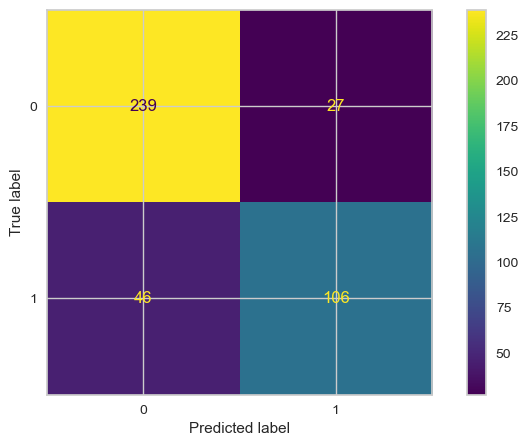

In [139]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(conf_matrix).plot(values_format='d');